# Quantum Circuits Image-to-Text Dataset
## Natural Language Processing and Information Retrieval
### Winster Semester 25

#### Name :- Somantha Manuranga
#### Matriculation Number:- 45314273



#### Overview
This notebook develops a reproducible method to classify quantum computing-related circuit images and other quantum computing-related images.Image-to-text models usually perform well on photographs but struggle with schematic or technical images. This project explores creating a small, specialized dataset to fine-tune such a model for schematics and evaluates the effort required.







This project compiles a dataset of quantum circuit schematics from recent "quant-ph" arXiv papers. The focus is on developing a method for dataset creation, ensuring quality, and selecting relevant images related to quantum computing.Here, my dataset number was *paper_list_45*. This list contains more than 25000 quantum computing papers.


 #### Project Submissions

Required deliverables:  

- JSON dataset of images and descriptions  
- Images of the quantum circuit-related folder with PNG images  
- CSV file image count 
- PDF documentation  
- Source code folder


Before Run this Notebook you should have to run download_arxiv_windows.py and html_figure_extractor.py files. But in the given folder you already have Figure_JSON file. With that you can run this python notebook file.

In [2]:
#All use Libraries for this notebook file

# Standard Python libraries
import os
import re
import time
import json

# Data processing and utilities
import pandas as pd
import numpy as np
from tqdm import tqdm

# Data manipulation and splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# Web scraping and XML parsing
import requests
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup

# PyTorch core
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# Transformers (BERT model training)
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)

# Visualization
import matplotlib.pyplot as plt


In [ ]:
# Install pipeline dependencies
!pip install requests beautifulsoup4 lxml

**Save the JSON files Locally**: Save the JSON files that you get after step 02 content to local files for further processing.{To get a better understanding, first read the attached readme file}

In Step 1 and Step 2, Python scripts were used to download 1,000 sample HTML files from the arXiv website in order to scrape information from a given list of quantum computing research papers. After running the second Python script, all the relevant scraped information was processed and saved as structured JSON files. Now you can run this python script safelt to train the BERT model.

Here, I have used the downloaded_html folder to generate all the figure captions and other required details into my JSON file. This initial JSON file included the details below.
1. arxiv_number as a string
2. page number initially, this is indicated as null
3. Figure number of the image in that paper
4. Figure caption of the image in that paper
5. Text positions indicating the beginning and the end position of the text's figure caption
6. Additionally, we save the original caption of the image with some cleaning of the text using Regular expressions.(This cleaned caption save as raw caption)

### Text Classification for Figure Captions

Text classification is a cornerstone of *natural language processing (NLP)*, enabling tasks such as:

* Sentiment analysis
* Spam detection
* Topic categorization

At the forefront of NLP advancements is *BERT (Bidirectional Encoder Representations from Transformers)*, a pre-trained transformer model renowned for its ability to understand *context in text*.

In this project, after preparing JSON files containing figure captions and metadata, we aim to *classify whether a figure is related to quantum circuits or not*.

One of the main challenges is the *limited amount of labeled data* required to train BERT’s multi-head attention layers effectively.

#### Data Collection Process

1. *Manual Labeling*--> Initially, 257 captions were manually labeled:

   * Quantum circuit-related caption → `1`
   * Not quantum circuit-related caption → `0`

2. *Data Augmentation*--> To increase the dataset, an LLM was used to *synthetically generate ~1,200 additional data points*, expanding the dataset to improve training effectiveness.




This ensures the data is structured, labeled, and ready for tokenization.

**Data Preparation and Splitting**

The dataset is split into train (80%), validation (10%), and test (10%) sets using stratified sampling to maintain consistent class distribution across all splits. This ensures balanced representation of quantum circuit and non-quantum circuit captions in each subset for reliable model training and evaluation.

In [3]:
# To work with this section you need to find out the "1285-Date" CSV file in the submitted folder

# Load your csv file
data = pd.read_csv("1285-Data.csv") 

# Quick sanity checks
print("Dataset shape:", data.shape)
print("\nFirst few rows:")
print(data.head())
print("\nLast few rows:")
print(data.tail())
print("\nClass distribution:")
print(data['label'].value_counts(0))

# Ensure labels are integers 0/1
data['label'] = data['label'].astype(int)

# First split: 80% train, 20% temp
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    data["caption"].values,
    data["label"].values,
    test_size=0.2,
    random_state=42,
    stratify=data["label"].values
)

# Second split: 10% val, 10% test
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

print("\nFinal split sizes:")
print(f"Train: {len(train_texts)} ({len(train_texts)/len(data)*100:.1f}%)")
print(f"Val:   {len(val_texts)}   ({len(val_texts)/len(data)*100:.1f}%)")
print(f"Test:  {len(test_texts)}  ({len(test_texts)/len(data)*100:.1f}%)")

print("\nClass distribution in each split:")
print(f"Train - Class 0: {sum(train_labels==0)}, Class 1: {sum(train_labels==1)}")
print(f"Val   - Class 0: {sum(val_labels==0)},   Class 1: {sum(val_labels==1)}")
print(f"Test  - Class 0: {sum(test_labels==0)},  Class 1: {sum(test_labels==1)}")


Dataset shape: (1285, 2)

First few rows:
                                             caption  label
0  The squeezing in Paul’s trap. The continuous l...      0
1  The trajectories generated by the single appli...      0
2                  Circuit for 2nd term in Table (3)      1
3  Illustration of the duality between an open sy...      0
4  Graphical representation of the view adopted i...      0

Last few rows:
                                                caption  label
1280  Plot showing quantum volume progression from 2...      0
1281  Diagram of quantum circuit employing rotation ...      1
1282  Quantum state tomography reconstruction for tw...      0
1283  Circuit for discrete quantum walk on line grap...      1
1284  Diagram of quantum circuit with ancilla qubit ...      1

Class distribution:
label
1    657
0    628
Name: count, dtype: int64

Final split sizes:
Train: 1028 (80.0%)
Val:   128   (10.0%)
Test:  129  (10.0%)

Class distribution in each split:
Train - Class 0: 

**Model Selection: SciBERT**

We use `allenai/scibert_scivocab_cased` instead of `bert-base-uncased` for this classification task. SciBERT was pre-trained on 1.14M scientific papers from Semantic Scholar, including arXiv publications, making it better suited for understanding quantum computing terminology. The **cased** version was specifically chosen to preserve the case sensitivity of quantum gate names (CNOT, CZ, SWAP), technical terms (Rabi oscillation, stabilizer measurement), and domain-specific notation where uppercase letters carry meaning. This typically yields 5-10% better accuracy on scientific text classification compared to general-domain BERT models.

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Use SciBERT for better scientific text performance
MODEL_NAME = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)


2025-12-21 18:03:33.206731: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
"""
Data Preparation Pipeline for Quantum Circuit Caption Classification
"""

class ClassificationDataset(Dataset):
    """
    Custom PyTorch Dataset for quantum circuit caption classification.
    """
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts[idx]),
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long),
        }


def load_and_split_data(file_path, random_state=42):
    """
    Load CSV and create 80-10-10 stratified split.

    """
    # Load data
    data = pd.read_csv(file_path, encoding='utf-8', encoding_errors='replace')
    
    # Clean data
    data['label'] = data['label'].astype(int)
    data['caption'] = data['caption'].astype(str).str.strip()
    
    print(f"Dataset: {len(data)} samples")
    print(f"Class distribution: {dict(data['label'].value_counts())}")
    
    # Split: 80% train, 20% temp
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        data["caption"].values,
        data["label"].values,
        test_size=0.2,
        random_state=random_state,
        stratify=data["label"].values
    )
    
    # Split temp: 50% val, 50% test (each 10% of total)
    val_texts, test_texts, val_labels, test_labels = train_test_split(
        temp_texts, temp_labels,
        test_size=0.5,
        random_state=random_state,
        stratify=temp_labels
    )
    
    print(f"Split: Train={len(train_texts)}, Val={len(val_texts)}, Test={len(test_texts)}")
    
    return (train_texts, train_labels, val_texts, val_labels, test_texts, test_labels)


# ================
# MAIN EXECUTION
# ================

# Configuration
MAX_LEN = 128
BATCH_SIZE = 16

# Load and split data
train_texts, train_labels, val_texts, val_labels, test_texts, test_labels = load_and_split_data(
    "1285-Data.csv"
)

#Create datasets
train_dataset = ClassificationDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = ClassificationDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = ClassificationDataset(test_texts, test_labels, tokenizer, MAX_LEN)

#Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False)

print(f"\nReady! Batches: Train={len(train_loader)}, Val={len(val_loader)}, Test={len(test_loader)}")

Dataset: 1285 samples
Class distribution: {1: 657, 0: 628}
Split: Train=1028, Val=128, Test=129

Ready! Batches: Train=65, Val=4, Test=5



## Optimizer and Learning Rate Schedule

AdamW optimizer with learning rate 2e-5 and weight decay 0.01 was used, following standard BERT fine-tuning configuration. A linear scheduler with 10% warmup steps gradually increases then decays the learning rate, preventing catastrophic forgetting of pre-trained knowledge. Training was limited to three epochs to avoid overfitting.


In [7]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

epochs = 3
total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # 10% warmup
    num_training_steps=total_steps,
)
print("Optimizer and scheduler set up.")

Optimizer and scheduler set up.


### Training Process

- Model fine-tuned for 3 epochs with training and validation phases per epoch
- Training phase (`model.train()`): computes gradients and updates weights via backpropagation
- Validation phase (`model.eval()`): evaluates generalization with gradients disabled (`torch.no_grad()`)
- Cross-entropy loss used for binary classification (quantum circuit vs non-circuit)
- Optimizer and scheduler updated after each batch to adjust learning rate
- Loss curves plotted to detect overfitting (validation loss increasing while training loss decreases)


Epoch 1: 100%|██████████████████████████████████████████████████████████████| 65/65 [06:03<00:00,  5.60s/it, loss=0.175]


Epoch 1 Train Loss: 0.3262
Epoch 1 Val Loss: 0.0644
--------------------------------------------------


Epoch 2: 100%|████████████████████████████████████████████████████████████| 65/65 [04:36<00:00,  4.26s/it, loss=0.00477]


Epoch 2 Train Loss: 0.0617
Epoch 2 Val Loss: 0.0338
--------------------------------------------------


Epoch 3: 100%|████████████████████████████████████████████████████████████| 65/65 [04:24<00:00,  4.08s/it, loss=0.00325]


Epoch 3 Train Loss: 0.0228
Epoch 3 Val Loss: 0.0270
--------------------------------------------------


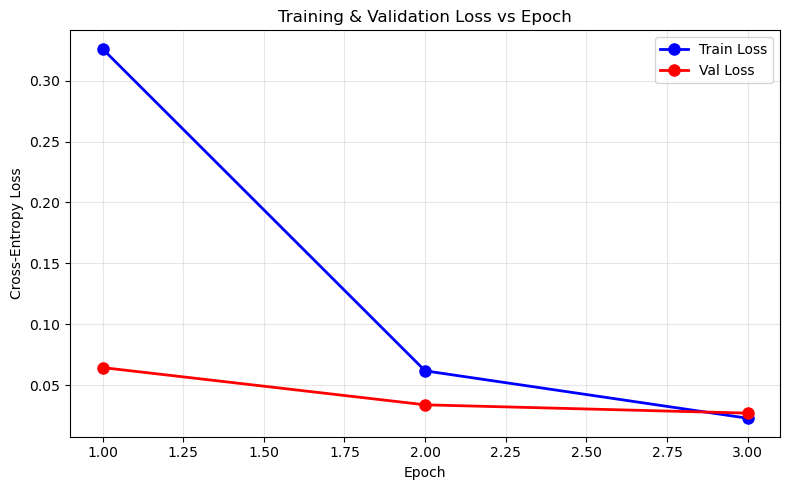

Training completed!


In [10]:
# Initialize lists for losses
epochs = 3
epoch_losses = []  # train losses
val_losses = []    # validation losses

for epoch in range(epochs):
    # Training phase
    model.train()
    total_loss = 0.0
    loop = tqdm(train_loader, leave=True)

    for batch in loop:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
        )
        loss = outputs.loss  # cross-entropy loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    # Calculate average training loss
    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1} Train Loss: {avg_loss:.4f}")

    # ===== VALIDATION PHASE =====
    model.eval()  # Switch to eval mode
    val_total_loss = 0.0
    with torch.no_grad():  # No gradients during validation
        for batch in val_loader:  # You need val_loader!
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            val_total_loss += outputs.loss.item()

    val_avg_loss = val_total_loss / len(val_loader)
    val_losses.append(val_avg_loss)
    print(f"Epoch {epoch+1} Val Loss: {val_avg_loss:.4f}")
    print("-" * 50)

# ---- Plot both train and val loss curves ----
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), epoch_losses, 'b-o', label='Train Loss', linewidth=2, markersize=8)
plt.plot(range(1, epochs+1), val_losses, 'r-o', label='Val Loss', linewidth=2, markersize=8)
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training & Validation Loss vs Epoch")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Training completed!")


### Model Evaluation

After training, the model is evaluated to measure its performance on the validation set. Metrics like accuracy, precision, recall, and F1 score are calculated.

In [11]:
# Here, model evaluation is done with Accuracy, Precision, Recall, and F1 Score
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:      # use test_loader here
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy  = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="weighted")
recall    = recall_score(all_labels, all_preds, average="weighted")
f1        = f1_score(all_labels, all_preds, average="weighted")

print(f"Test Accuracy : {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall   : {recall:.4f}")
print(f"Test F1-score : {f1:.4f}")


Test Accuracy : 0.9535
Test Precision: 0.9553
Test Recall   : 0.9535
Test F1-score : 0.9535


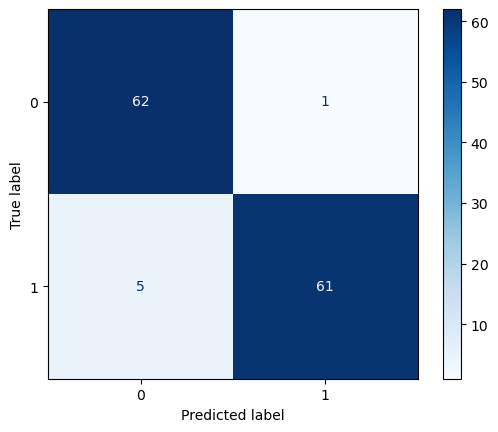

In [12]:
#Visualise the Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues') 
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()  



In [13]:

"""
Per-class metrics (class 0 and class 1 separately)
"""

precision_per_class = precision_score(all_labels, all_preds, average=None)
recall_per_class    = recall_score(all_labels, all_preds, average=None)
f1_per_class        = f1_score(all_labels, all_preds, average=None)

print("Per-class Precision:", precision_per_class)
print("Per-class Recall   :", recall_per_class)
print("Per-class F1       :", f1_per_class)


Per-class Precision: [0.92537313 0.98387097]
Per-class Recall   : [0.98412698 0.92424242]
Per-class F1       : [0.95384615 0.953125  ]


### Saving the Model

Saving the trained model, tokenizer, and label encoder allows us to reuse them for predictions or further training.

In [14]:
save_dir = "Quantum_circuit_figure_caption_Classifier"

# Save fine-tuned model (weights + config)
model.save_pretrained(save_dir)

# Save tokenizer
tokenizer.save_pretrained(save_dir)

print(f" Model and tokenizer saved to: {save_dir}")


 Model and tokenizer saved to: Quantum_circuit_figure_caption_Classifier


### Inference

Finally, we use the saved model to classify new text data.

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your saved model and tokenizer
load_dir = "Quantum_circuit_figure_caption_Classifier"  # your folder name
model = AutoModelForSequenceClassification.from_pretrained(load_dir).to(device)
tokenizer = AutoTokenizer.from_pretrained(load_dir)
model.eval()

# Define mapping from class ID to label string
id2label = {
    0: "Non Quantum Circuit Figure",   # e.g., "Not_Figure_Caption"
    1: "Quantum Circuit Figure",   # e.g., "Figure_Caption"
}

# Function to classify a single text
def predict_label(text):
    enc = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=128,
    )
    enc = {k: v.to(device) for k, v in enc.items()}

    with torch.no_grad():
        outputs = model(**enc)
        pred_id = torch.argmax(outputs.logits, dim=1).item()

    return pred_id, id2label[pred_id]




### Now we are going to do our JSON file classification task



In [18]:
"""
Quantum Circuit JSON Filter with Confidence Threshold

Same as before, but only treats a prediction as Quantum Circuit (class 1)
if the confidence is >= 0.7. Also removes raw_caption from saved JSONs.
"""
# ============ CONFIGURATION ============
INPUT_FOLDER = "Figure_JSON"
OUTPUT_FOLDER = "Filtered_Quantum_Circuit_Figures"
MODEL_PATH = "Quantum_circuit_figure_caption_Classifier"
MAX_QUANTUM_CIRCUITS = 250

# Confidence threshold for class 1 (70%)
CONF_THRESHOLD = 0.87  # <<< change here if needed
# ============ END CONFIGURATION ============


def load_model(model_path):
    """Load the trained BERT classifier and tokenizer."""
    print(f"Loading model from: {model_path}")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model.eval()
    
    print("Model loaded successfully!\n")
    return model, tokenizer, device


def predict_label(text, model, tokenizer, device):
    """
    Predict whether a caption is quantum circuit related.
    
    Returns:
        pred_id: 0 = Non Quantum Circuit, 1 = Quantum Circuit
        pred_label: String label
        confidence: Probability of predicted class
    """
    id2label = {
        0: "Non Quantum Circuit Figure",
        1: "Quantum Circuit Figure",
    }
    
    enc = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=128,
    )
    enc = {k: v.to(device) for k, v in enc.items()}
    
    with torch.no_grad():
        outputs = model(**enc)
        probs = torch.softmax(outputs.logits, dim=1)
        pred_id = torch.argmax(outputs.logits, dim=1).item()
        confidence = probs[0][pred_id].item()
    
    return pred_id, id2label[pred_id], confidence


def process_json_file(json_path):
    """Read a JSON file and return its content."""
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        return data
    except Exception as e:
        print(f"  [ERROR] Failed to read {json_path}: {e}")
        return None


def save_json_file(data, output_path):
    """Save data to JSON file with proper formatting. Removes raw_caption."""
    # Remove raw_caption from all levels of the data structure
    def remove_raw_caption(obj):
        if isinstance(obj, dict):
            obj_copy = obj.copy()
            obj_copy.pop('raw_caption', None)  # Remove from top level
            for key, value in obj_copy.items():
                obj_copy[key] = remove_raw_caption(value)
            return obj_copy
        elif isinstance(obj, list):
            return [remove_raw_caption(item) for item in obj]
        else:
            return obj
    
    cleaned_data = remove_raw_caption(data)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(cleaned_data, f, indent=2, ensure_ascii=False)


def get_raw_caption_from_json(data):
    """
    Extract raw_caption text from JSON data for BERT classification.
    Handles both single record and multi-record JSON formats.
    """
    if isinstance(data, dict):
        if 'raw_caption' in data:
            return data.get('raw_caption', '')
        
        for key, value in data.items():
            if isinstance(value, dict) and 'raw_caption' in value:
                return value.get('raw_caption', '')
    
    elif isinstance(data, list):
        if len(data) > 0 and isinstance(data[0], dict):
            return data[0].get('raw_caption', '')
    
    return ''


def main():
    print("=" * 70)
    print("  Quantum Circuit JSON Filter")
    print("  Using BERT Classifier to filter quantum circuit figures")
    print("  (Classifying on raw_caption field)")
    print(f"  Confidence threshold for class 1: {CONF_THRESHOLD * 100:.0f}%")
    print("  raw_caption will be REMOVED from saved JSONs")
    print("=" * 70)
    print()
    
    if not os.path.exists(INPUT_FOLDER):
        print(f"ERROR: Input folder '{INPUT_FOLDER}' not found!")
        print(f"Please make sure the folder exists in: {os.getcwd()}")
        return
    
    if not os.path.exists(MODEL_PATH):
        print(f"ERROR: Model folder '{MODEL_PATH}' not found!")
        print(f"Please make sure the trained model exists in: {os.getcwd()}")
        return
    
    model, tokenizer, device = load_model(MODEL_PATH)
    
    os.makedirs(OUTPUT_FOLDER, exist_ok=True)
    
    total_folders = 0
    total_json_files = 0
    quantum_circuit_count = 0
    non_quantum_count = 0
    folders_with_quantum = 0
    skipped_empty_folders = 0
    error_count = 0
    
    subfolders = [f for f in os.listdir(INPUT_FOLDER) 
                  if os.path.isdir(os.path.join(INPUT_FOLDER, f))]
    
    print(f"Found {len(subfolders)} subfolders to process\n")
    print("-" * 70)
    
    reached_limit = False
    for subfolder in tqdm(subfolders, desc="Processing folders"):
        if reached_limit:
            break
            
        subfolder_path = os.path.join(INPUT_FOLDER, subfolder)
        total_folders += 1
        
        json_files = [f for f in os.listdir(subfolder_path) 
                      if f.endswith('.json')]
        
        if not json_files:
            skipped_empty_folders += 1
            continue
        
        quantum_jsons = []
        
        for json_file in json_files:
            json_path = os.path.join(subfolder_path, json_file)
            total_json_files += 1
            
            data = process_json_file(json_path)
            if data is None:
                error_count += 1
                continue
            
            text_for_cls = get_raw_caption_from_json(data)
            
            if not text_for_cls or len(text_for_cls.strip()) < 5:
                non_quantum_count += 1
                continue
            
            pred_id, pred_label, confidence = predict_label(
                text_for_cls, model, tokenizer, device
            )
            
            # <<< Threshold logic: only accept class 1 if confidence >= CONF_THRESHOLD
            if pred_id == 1 and confidence >= CONF_THRESHOLD:
                quantum_circuit_count += 1
                quantum_jsons.append((json_file, data))
                
                if quantum_circuit_count >= MAX_QUANTUM_CIRCUITS:
                    print(f"\n\n>>> Reached {MAX_QUANTUM_CIRCUITS} quantum circuit figures! Stopping...")
                    reached_limit = True
                    break
            else:
                non_quantum_count += 1
        
        if quantum_jsons:
            folders_with_quantum += 1
            output_subfolder = os.path.join(OUTPUT_FOLDER, subfolder)
            os.makedirs(output_subfolder, exist_ok=True)
            
            for json_file, data in quantum_jsons:
                output_path = os.path.join(output_subfolder, json_file)
                save_json_file(data, output_path)
    
    print("\n" + "=" * 70)
    print("  FILTERING COMPLETE")
    if reached_limit:
        print(f"  (Stopped early - reached {MAX_QUANTUM_CIRCUITS} quantum circuits)")
    print("=" * 70)
    print(f"\n  Input folder:  {INPUT_FOLDER}")
    print(f"  Output folder: {OUTPUT_FOLDER}")
    print(f"  Target limit:  {MAX_QUANTUM_CIRCUITS} quantum circuit figures")
    print(f"  Confidence threshold: {CONF_THRESHOLD * 100:.0f}%")
    print()
    print(f"  Total folders processed:      {total_folders}")
    print(f"  Total JSON files processed:   {total_json_files}")
    print()
    print(f"  Quantum Circuit figures:      {quantum_circuit_count} (Class 1, conf >= {CONF_THRESHOLD})")
    print(f"  Non-Quantum Circuit figures:  {non_quantum_count} (Class 0 or conf < {CONF_THRESHOLD})")
    print()
    print(f"  Folders with quantum circuits: {folders_with_quantum}")
    print(f"  Empty/skipped folders:         {skipped_empty_folders}")
    print(f"  Errors:                        {error_count}")
    print()
    print(f"  Output saved to: {os.path.abspath(OUTPUT_FOLDER)}")
    print("  All raw_caption fields REMOVED from output JSONs")
    print("=" * 70)


if __name__ == "__main__":
    main()


  Quantum Circuit JSON Filter
  Using BERT Classifier to filter quantum circuit figures
  (Classifying on raw_caption field)
  Confidence threshold for class 1: 87%
  raw_caption will be REMOVED from saved JSONs

Loading model from: Quantum_circuit_figure_caption_Classifier
Using device: cuda


OutOfMemoryError: CUDA out of memory. Tried to allocate 92.00 MiB. GPU 0 has a total capacity of 7.60 GiB of which 20.12 MiB is free. Process 77999 has 794.00 MiB memory in use. Process 216517 has 118.00 MiB memory in use. Process 3071125 has 3.10 GiB memory in use. Process 3073962 has 2.53 GiB memory in use. Including non-PyTorch memory, this process has 852.00 MiB memory in use. Of the allocated memory 658.70 MiB is allocated by PyTorch, and 47.30 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [1]:
#After classifying the JSON files using the trained model, we record in a CSV file how many images are associated with each classification code.
#This code section handles the CSV writing process. 
#An image limit of 250 is applied, and the process stops once 250 images have been written to the CSV file.

# to run

# Paths - adjust these to your notebook paths
csv_path = 'All codes.csv'  # Your CSV file
base_dir = 'Filtered_Quantum_Circuit_Figures'  # Main folder with subfolders
output_path = 'All_codes_updated.csv'

# Read CSV file
df = pd.read_csv(csv_path)
print(f"Loaded CSV with {len(df)} rows")

# Dictionary to store JSON counts for each arXiv code
counts = {}

# Process subfolders (stop after 245)
processed_count = 0

for subfolder_name in os.listdir(base_dir):
    subfolder_path = os.path.join(base_dir, subfolder_name)
    
    # Skip if not a directory
    if not os.path.isdir(subfolder_path):
        continue
    
    # Extract arXiv code from subfolder name like "00055_arXiv_2412.04264"
    match = re.search(r'^\d+_arXiv_(.+)$', subfolder_name)
    if match:
        arxiv_code = match.group(1)
        
        # Count JSON files in this subfolder
        json_files = [f for f in os.listdir(subfolder_path) 
                     if f.endswith('.json')]
        counts[arxiv_code] = len(json_files)
        
        processed_count += 1
        print(f"Processed {subfolder_name}: {arxiv_code} -> {len(json_files)} JSON files")
        
        # Stop after 245 subfolders
        if processed_count >= 250:
            print("Reached 250 subfolders limit - stopping")
            break

print(f"\nProcessed {processed_count} subfolders")
print("Available counts:", list(counts.keys())[:10])  # Show first 10

# Extract arXiv codes from CSV and map counts
code_column = df.columns[0]  # Assuming first column has codes like "arXiv:2412.04264"

def extract_arxiv_code(text):
    match = re.search(r'arXiv:(\d+\.\d+)', str(text))
    return match.group(1) if match else None

# Add json_count column (default 0)
df['json_count'] = 0

for idx, row in df.iterrows():
    full_code = row[code_column]
    arxiv_code = extract_arxiv_code(full_code)
    
    if arxiv_code and arxiv_code in counts:
        df.at[idx, 'json_count'] = counts[arxiv_code]
        print(f"Matched {full_code} -> {counts[arxiv_code]}")
    else:
        df.at[idx, 'json_count'] = 0
        if arxiv_code:
            print(f"No match for {arxiv_code} -> 0")

# Save updated CSV
df.to_csv(output_path, index=False)
print(f"\n✅ Updated CSV saved: {output_path}")
print("\nSample output:")
print(df[['json_count']].head(10).to_string(index=False))


Loaded CSV with 26906 rows
Processed 00964_arXiv_2507.03092: 2507.03092 -> 1 JSON files
Processed 00509_arXiv_2407.06415: 2407.06415 -> 4 JSON files
Processed 00642_arXiv_2401.10622: 2401.10622 -> 1 JSON files
Processed 00328_arXiv_2404.17560: 2404.17560 -> 1 JSON files
Processed 00192_arXiv_2401.14993: 2401.14993 -> 1 JSON files
Processed 00368_arXiv_2502.17301: 2502.17301 -> 1 JSON files
Processed 00686_arXiv_2504.16246: 2504.16246 -> 2 JSON files
Processed 00422_arXiv_2509.24766: 2509.24766 -> 2 JSON files
Processed 00783_arXiv_2401.08110: 2401.08110 -> 1 JSON files
Processed 00849_arXiv_2503.20683: 2503.20683 -> 1 JSON files
Processed 00531_arXiv_2409.11020: 2409.11020 -> 2 JSON files
Processed 00884_arXiv_2407.13672: 2407.13672 -> 3 JSON files
Processed 00354_arXiv_2401.08762: 2401.08762 -> 1 JSON files
Processed 00543_arXiv_2409.05676: 2409.05676 -> 2 JSON files
Processed 00314_arXiv_2412.09768: 2412.09768 -> 1 JSON files
Processed 00301_arXiv_2411.18581: 2411.18581 -> 1 JSON fil

**After you work with this Notebook file you need to go through Main 02 Notebook file for further procceses of this project**
You can find in Main_02 notebook file :
1. Page number detection and updating the clasifed JSON files.
2. To work with the process of image file floder creation
